In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics 
import scipy.stats as stats
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
sns.set(rc={'figure.figsize':(11, 4)})
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn import tree
from sklearn.metrics import r2_score
from xgboost import XGBRegressor as XGBR
import xgboost as xgb
import datetime
import pickle

In [15]:
df=pd.read_csv('STD_outlier_dataset.csv')
df['deliverydate'] = pd.to_datetime(df['deliverydate'],format = "%Y-%m-%d")

In [16]:
df["rolling_qty_7D"] = df['shippedqty'].rolling(window= 7, min_periods=1).sum().astype(int)
df["rolling_sales_14D"] = df['shippedqty'].rolling(window= 14, min_periods=1).sum().astype(int)

In [17]:
rowcount  = 0
for row in open("STD_outlier_dataset.csv"):
    rowcount+= 1
print("Number of lines present:", rowcount)
rows=int(rowcount*0.3)
rows
train=df.iloc[:-rows]
test=df.iloc[-rows:]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)

Number of lines present: 267
Train Dataset: (186, 4)
Test Dataset: (80, 4)


In [18]:
b = []
for i in train.keys():
    b.append(i)
b.remove('deliverydate')
print(b)

['shippedqty', 'rolling_qty_7D', 'rolling_sales_14D']


In [19]:
X_train = train[b].values
X_test = test[b].values
y_train = train['shippedqty'].values
y_test = test['shippedqty'].values

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train,y_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [20]:
dtest=xgb.DMatrix(X_test,y_test)

In [21]:
loaded_model=pickle.load(open("xgboostSTD.dat","rb"))
print("Loaded model from:xgboostSTD.dat")

Loaded model from:xgboostSTD.dat


In [22]:
ypreds=loaded_model.predict(dtest)
print("MSE:",MSE(y_test,ypreds))
print("R2:",r2_score(y_test,ypreds))

MSE: 102874478566.63356
R2: 0.9713246436495854


In [23]:
df_pred = pd.DataFrame({'deliverydate': test['deliverydate'], 'Actual': y_test, 'Predicted': ypreds})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)

In [24]:
Actual_pred = df_pred.groupby(df_pred["deliverydate"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["deliverydate"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['deliverydate'] = date_pred
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 1.0328940611989463 % of items will not sale by this model.


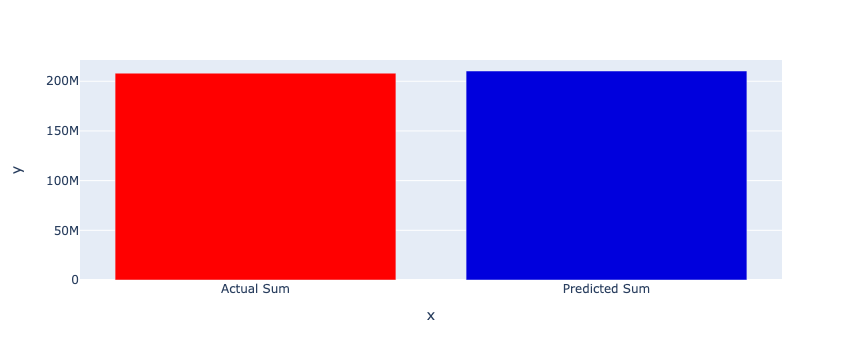

In [25]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

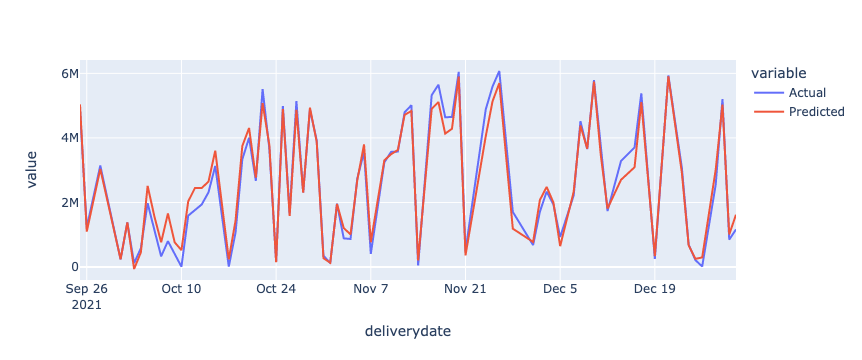

In [26]:
fig = px.line(df_pred1, x='deliverydate', y=["Actual","Predicted"])
fig.show()